In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# ระบุ path ของโฟลเดอร์ที่เก็บไฟล์
input_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Dataset"
output_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Cropped_Objects"

# ตรวจสอบว่าโฟลเดอร์ output มีอยู่หรือไม่ ถ้าไม่มีก็สร้างขึ้นมา
os.makedirs(output_folder, exist_ok=True)

# ฟังก์ชันสำหรับการแสดง Threshold ต่างๆ
def find_object_with_threshold(original_image, gray_image, threshold_value):
    # ใช้ Threshold เพื่อแยก object
    _, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    # หา Contours ของ object
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ตรวจสอบว่ามีวัตถุหรือไม่
    if len(contours) == 0:
        return None

    # วาด Contours และหาส่วนที่ใหญ่ที่สุด
    largest_contour = max(contours, key=cv2.contourArea)  # หา contour ที่มีขนาดใหญ่ที่สุด
    x, y, w, h = cv2.boundingRect(largest_contour)  # หาพื้นที่สี่เหลี่ยมที่ล้อมรอบ object

    # Crop เฉพาะส่วน object จากภาพต้นฉบับ
    cropped_object = original_image[y:y+h, x:x+w]
    
    return cropped_object, x, y, w, h

# วนลูปผ่านไฟล์ทั้งหมดในโฟลเดอร์
for file_name in os.listdir(input_folder):
    if file_name.endswith(".png") and ("-5" in file_name or "-15" in file_name):  # เลือกเฉพาะไฟล์ที่ตรงตามเงื่อนไข
        file_path = os.path.join(input_folder, file_name)

        # โหลดรูปภาพ
        image = cv2.imread(file_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # แปลงเป็นภาพสีเทา

        # ทดลองค่า Threshold
        threshold_value = 5
        result = find_object_with_threshold(image, gray_image, threshold_value)

        if result is not None:
            cropped_object, x, y, w, h = result
            
            # บันทึกไฟล์ที่ crop
            save_path = os.path.join(output_folder, file_name)
            cv2.imwrite(save_path, cropped_object)
            #print(f"บันทึกไฟล์: {save_path}")
        else:
            #print(f"ไม่พบวัตถุในไฟล์: {file_name} ที่ Threshold: {threshold_value}")


In [ ]:
import cv2
import numpy as np
import os

# ระบุ path ของโฟลเดอร์ภาพ
input_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Cropped_Objects"
output_folder = r"C:\Users\BMEI CMU\Documents\G6PD\Split_Images"

# สร้างโฟลเดอร์สำหรับบันทึกผลลัพธ์ (ถ้ายังไม่มี)
os.makedirs(output_folder, exist_ok=True)

# วนลูปอ่านไฟล์ในโฟลเดอร์
for file_name in os.listdir(input_folder):
    if file_name.endswith(".png") and ("-5" in file_name or "-15" in file_name):  # ตรวจสอบชื่อไฟล์
        file_path = os.path.join(input_folder, file_name)

        # โหลดภาพต้นฉบับแบบสี (BGR)
        image_color = cv2.imread(file_path, cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)  # แปลงเป็น RGB

        # แปลงภาพเป็น Grayscale
        image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

        # แบ่งภาพเป็น 3 ส่วนในแนวตั้ง
        height, width = image_gray.shape
        part_width = width // 3
        middle_section = image_gray[:, part_width:2 * part_width]  # ส่วนตรงกลาง

        # คำนวณค่าเฉลี่ยความเข้มแสงของพื้นที่ตรงกลาง
        middle_intensity = np.mean(middle_section, axis=0)

        # หาตำแหน่งที่ค่าความเข้มแสงต่ำที่สุดในส่วนกลาง
        middle_black_x_relative = np.argmin(middle_intensity)

        # คำนวณตำแหน่งที่แท้จริงในภาพต้นฉบับ
        middle_black_x = middle_black_x_relative + part_width

        # ตรวจสอบความถูกต้อง: หากค่าต่ำสุดไม่สมเหตุสมผล ให้ใช้การแบ่งครึ่งแทน
        if middle_black_x <= 0 or middle_black_x >= width:
            middle_black_x = width // 2

        # แบ่งภาพต้นฉบับออกเป็นซ้ายและขวา
        left_half = image_rgb[:, :middle_black_x, :]  # ส่วนซ้าย
        right_half = image_rgb[:, middle_black_x:, :]  # ส่วนขวา

        # บันทึกภาพซ้ายและขวา
        left_file_name = f"{os.path.splitext(file_name)[0]}_left.png"
        right_file_name = f"{os.path.splitext(file_name)[0]}_right.png"
        cv2.imwrite(os.path.join(output_folder, left_file_name), cv2.cvtColor(left_half, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(output_folder, right_file_name), cv2.cvtColor(right_half, cv2.COLOR_RGB2BGR))

        print(f"บันทึก: {left_file_name} และ {right_file_name} เรียบร้อย")

# สรุปผลลัพธ์
print(f"การแบ่งภาพเสร็จสมบูรณ์! ผลลัพธ์ถูกบันทึกในโฟลเดอร์: {output_folder}")

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# เส้นทางพาธหลักที่ไฟล์จะถูกค้นหา
base_path = r'C:\Users\BMEI CMU\Documents\G6PD\Split_Images'

# เส้นทางที่จะบันทึกภาพที่แปลงแล้ว
output_path = r'C:\Users\BMEI CMU\Documents\G6PD\YIQ_Images'

# สร้างโฟลเดอร์ย่อยสำหรับ Y, I, Q
y_path = os.path.join(output_path, 'Y_Channel')
i_path = os.path.join(output_path, 'I_Channel')
q_path = os.path.join(output_path, 'Q_Channel')

# ตรวจสอบและสร้างโฟลเดอร์หากไม่มีอยู่
os.makedirs(y_path, exist_ok=True)
os.makedirs(i_path, exist_ok=True)
os.makedirs(q_path, exist_ok=True)

# ค้นหาไฟล์ทั้งหมดที่ลงท้ายด้วย _left.png และ _right.png
file_paths = glob(os.path.join(base_path, '*_left.png')) + glob(os.path.join(base_path, '*_right.png'))

# วนลูปเพื่อโหลดและแปลงไฟล์ต่างๆ
for image_path in file_paths:
    # อ่านภาพ
    image = cv2.imread(image_path)

    # ตรวจสอบว่าไฟล์ถูกโหลดได้หรือไม่
    if image is None:
        print(f"ไม่สามารถโหลดภาพจาก {image_path}")
        continue  # ข้ามไฟล์นี้และไปไฟล์ถัดไป

    # แปลงภาพเป็น YUV color space
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # สร้างเมทริกซ์การแปลงจาก YUV เป็น YIQ
    def yuv_to_yiq(yuv):
        conversion_matrix = np.array([[0.299, 0.587, 0.114],
                                      [0.596, -0.274, -0.322],
                                      [0.211, -0.523, 0.311]])
        yiq_image = np.dot(yuv.reshape((-1, 3)), conversion_matrix.T)
        return yiq_image.reshape(yuv.shape)

    # แปลงภาพจาก YUV เป็น YIQ
    yiq_image = yuv_to_yiq(yuv_image)

    # ดึงชื่อไฟล์และส่วนขยายออกจากเส้นทางไฟล์
    filename = os.path.basename(image_path)
    filename_without_ext, ext = os.path.splitext(filename)

    # บันทึกช่อง Y, I, Q แยกในโฟลเดอร์ย่อย
    plt.imsave(os.path.join(y_path, f'{filename_without_ext}_Y.png'), yiq_image[..., 0], cmap='gray')  # บันทึกช่อง Y
    plt.imsave(os.path.join(i_path, f'{filename_without_ext}_I.png'), yiq_image[..., 1], cmap='gray')  # บันทึกช่อง I
    plt.imsave(os.path.join(q_path, f'{filename_without_ext}_Q.png'), yiq_image[..., 2], cmap='gray')  # บันทึกช่อง Q

In [14]:
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob

# เส้นทางพาธหลักที่ไฟล์จะถูกค้นหา
base_path = r'C:\Users\BMEI CMU\Documents\G6PD\Split_Images'

# เส้นทางที่จะบันทึกภาพที่แปลงแล้ว
output_path = r'C:\Users\BMEI CMU\Documents\G6PD\HSV_Images'

# สร้างโฟลเดอร์ย่อยสำหรับ H, S, V
h_path = os.path.join(output_path, 'H_Channel')
s_path = os.path.join(output_path, 'S_Channel')
v_path = os.path.join(output_path, 'V_Channel')

# ตรวจสอบและสร้างโฟลเดอร์หากไม่มีอยู่
os.makedirs(h_path, exist_ok=True)
os.makedirs(s_path, exist_ok=True)
os.makedirs(v_path, exist_ok=True)

# ค้นหาไฟล์ทั้งหมดที่ลงท้ายด้วย _left.png และ _right.png
file_paths = glob(os.path.join(base_path, '*_left.png')) + glob(os.path.join(base_path, '*_right.png'))

# วนลูปเพื่อโหลดและแปลงไฟล์ต่างๆ
for image_path in file_paths:
    # อ่านภาพ
    image = cv2.imread(image_path)

    # ตรวจสอบว่าไฟล์ถูกโหลดได้หรือไม่
    if image is None:
        print(f"ไม่สามารถโหลดภาพจาก {image_path}")
        continue  # ข้ามไฟล์นี้และไปไฟล์ถัดไป

    # แปลงภาพเป็น HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # ดึงชื่อไฟล์และส่วนขยายออกจากเส้นทางไฟล์
    filename = os.path.basename(image_path)
    filename_without_ext, ext = os.path.splitext(filename)

    # บันทึกช่อง H, S, V แยกในโฟลเดอร์ย่อย
    plt.imsave(os.path.join(h_path, f'{filename_without_ext}_H.png'), hsv_image[..., 0], cmap='gray')  # บันทึกช่อง H
    plt.imsave(os.path.join(s_path, f'{filename_without_ext}_S.png'), hsv_image[..., 1], cmap='gray')  # บันทึกช่อง S
    plt.imsave(os.path.join(v_path, f'{filename_without_ext}_V.png'), hsv_image[..., 2], cmap='gray')  # บันทึกช่อง V

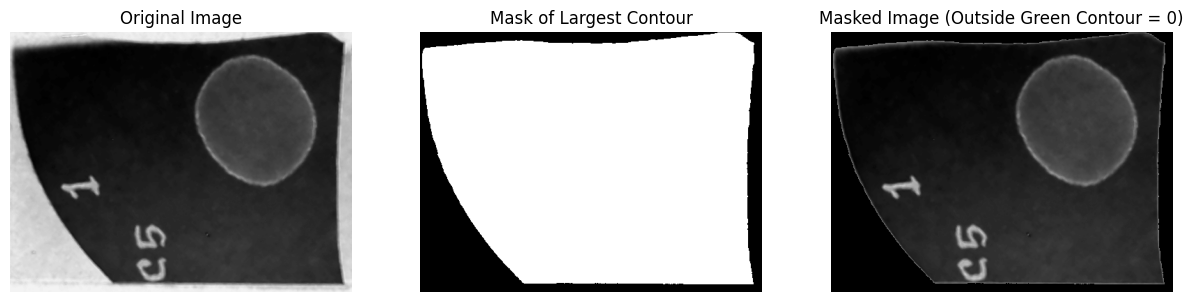

Area of the largest black object: 148052.0


In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r'C:\Users\BMEI CMU\Documents\G6PD\YIQ_Images\Q_Channel\1-5_left_Q.png'
original_image = cv2.imread(image_path)  # โหลดภาพต้นฉบับในโหมดสี
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # โหลดภาพในโหมด Grayscale

# Apply binary threshold
threshold = 128  # ค่า threshold (สามารถปรับได้)
_, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

# Invert the binary image to focus on black objects
inverted_binary = cv2.bitwise_not(binary_image)

# Find contours of black objects
contours, _ = cv2.findContours(inverted_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the largest contour
mask = np.zeros_like(image)  # สร้างภาพว่างที่มีขนาดเท่ากับภาพ Grayscale
cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)  # วาดพื้นที่ contour ลงใน mask

# Apply the mask to the original image
masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)  # เก็บเฉพาะพื้นที่ใน contour

# Display the results
plt.figure(figsize=(15, 8))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Mask
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask of Largest Contour")
plt.axis('off')

# Masked Image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image (Outside Green Contour = 0)")
plt.axis('off')

plt.show()

# Print the area of the largest contour
largest_area = cv2.contourArea(largest_contour)
print(f"Area of the largest black object: {largest_area}")

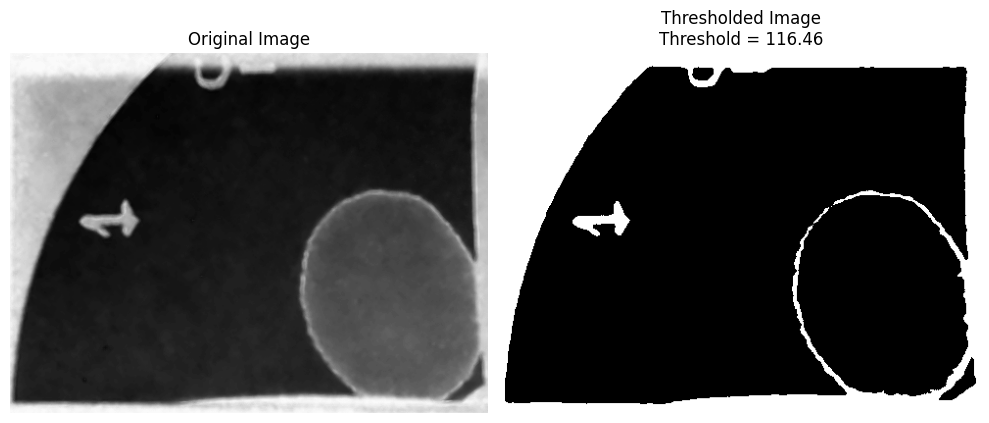

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the adaptive threshold function
def adaptive_threshold(img, min_intensity=None, max_intensity=None):
    if min_intensity is None or max_intensity is None:
        non_zero_pixels = img[img != 0]
        max_intensity = np.max(non_zero_pixels)
        min_intensity = np.min(non_zero_pixels)

    T = min_intensity + (max_intensity - min_intensity) * np.random.rand()
    newT = float('inf')
    k = 0

    while k != 500:
        G1 = img[img <= T]
        G2 = img[img > T]

        G1_nonzero = G1[G1 != 0]
        M1 = np.sum(G1_nonzero) / len(G1_nonzero) if len(G1_nonzero) > 0 else 0
        M2 = np.sum(G2) / len(G2) if len(G2) > 0 else 0

        newT = (M1 + M2) / 2

        if T == newT:
            break
        else:
            T = newT

        k += 1

    return T

# Load the uploaded image
image_path = r'C:\Users\BMEI CMU\Documents\G6PD\YIQ_Images\Q_Channel\1-5_left_Q.png'
img = cv2.imread(image_path)

# Apply the adaptive threshold function
threshold_value = adaptive_threshold(img)

# Plot the original image and the thresholded result
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Thresholded image
thresholded_img = (img > threshold_value).astype(np.uint8) * 255
plt.subplot(1, 2, 2)
plt.imshow(thresholded_img, cmap='gray')
plt.title(f"Thresholded Image\nThreshold = {threshold_value:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()
